In [31]:
import numpy as np
import pandas as pd

import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import *

/Users/saadkhan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/saadkhan/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/saadkhan/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

In [3]:
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shop = pd.read_csv('data/shops.csv')

In [5]:
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


In [46]:
train.head()
train.item_id.nunique()

21806

In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
# Remove duplicated rows
print('Before drop train shape:', train.shape)
train.drop_duplicates(subset=['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], keep='first', inplace=True)
train.reset_index(drop=True, inplace=True)
print('After drop train shape:', train.shape)

Before drop train shape: (2935849, 6)
After drop train shape: (2935825, 6)


In [9]:
# Check for outliers
print('item_price Stats')
print('Min: ', train.item_price.min())
print('Max: ', train.item_price.max())
print('Mean: ', train.item_price.mean())
print('Median: ', train.item_price.median())
print(' ')
print(train.item_price.value_counts().sort_index(ascending=False))

item_price Stats
Min:  -1.0
Max:  307980.0
Mean:  890.8557861463664
Median:  399.0
 
 307980.000000       1
 59200.000000        1
 50999.000000        1
 49782.000000        1
 42990.000000        4
 42000.000000        1
 41990.000000        3
 40991.000000        1
 40900.000000        1
 37991.000000        2
 36990.000000        4
 35991.000000        1
 35990.000000        3
 35490.000000        5
 35300.000000        5
 35192.000000        1
 34990.000000       12
 34490.000000        1
 33990.000000        1
 33490.000000        8
 32997.500000        1
 32990.000000       57
 32490.000000        4
 32437.000000        1
 32382.000000        1
 32199.000000       16
 32092.000000        1
 31990.000000       19
 31699.000000        1
 31599.000000        1
                  ... 
 4.400000            1
 4.333333            1
 4.300000            1
 4.235294            1
 4.142857            1
 4.055556            1
 4.029126            1
 4.000000          105
 3.800000         

In [10]:
# Remove -1 and 307980
print('before train shape:', train.shape)
train = train[(train.item_price > 0) & (train.item_price < 300000)]
print('after train shape:', train.shape)

before train shape: (2935825, 6)
after train shape: (2935823, 6)


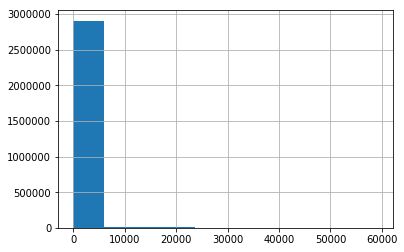

In [11]:
train.item_price.hist()


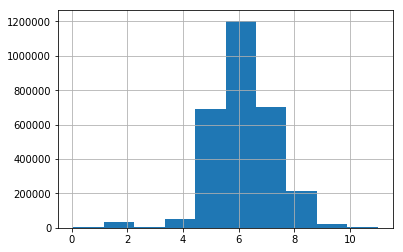

In [12]:
train.item_price.map(np.log1p).hist()


In [13]:
train.loc[:, 'item_price'] = train.item_price.map(np.log1p)

In [14]:
print('item_cnt_day Stats')
print('Min: ', train.item_cnt_day.min())
print('Max: ', train.item_cnt_day.max())
print('Mean: ', train.item_cnt_day.mean())
print('Median', train.item_cnt_day.median())

item_cnt_day Stats
Min:  -22.0
Max:  2169.0
Mean:  1.2426430339976218
Median 1.0


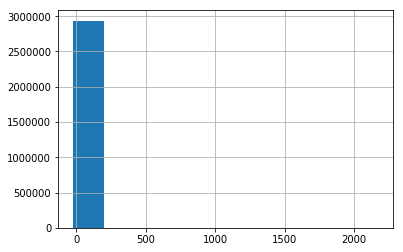

In [15]:
train.item_cnt_day.hist()

Text(0.5,1,'Sales per month')

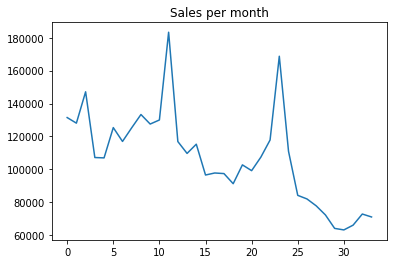

In [16]:
plt.plot(train.groupby('date_block_num').sum()['item_cnt_day'])
plt.title('Sales per month')

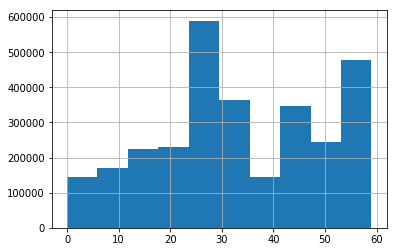

In [17]:
train.shop_id.hist()

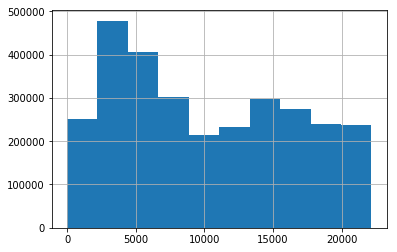

In [18]:
train.item_id.hist()

In [19]:
print('Overall Counts:')
print('# of date_block_num:', train.date_block_num.nunique())
print('# of shop ids:', train.shop_id.nunique())
print('# of item ids:', train.item_id.nunique())
print('max # of total combinations:', train.date_block_num.nunique()*train.shop_id.nunique()*train.item_id.nunique())

Overall Counts:
# of date_block_num: 34
# of shop ids: 60
# of item ids: 21806
max # of total combinations: 44484240


In [20]:
# Create new DF with store and item combinations for each month
from itertools import product
new_train = []
index_cols = ['date_block_num', 'shop_id', 'item_id']
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    new_train.append(np.array(list(product(*[[block_num], cur_shops, cur_items])), dtype='int32'))

new_train = pd.DataFrame(np.vstack(new_train), columns = index_cols, dtype=np.int32)

In [21]:
new_train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,6.907755,1.0
1,03.01.2013,0,25,2552,6.802395,1.0
2,05.01.2013,0,25,2552,6.802395,-1.0
3,06.01.2013,0,25,2554,7.444278,1.0
4,15.01.2013,0,25,2555,7.003065,1.0


In [23]:
train_month = train.groupby(['date_block_num', 'shop_id','item_id'], as_index=False).item_cnt_day.sum()
train_month = train_month.rename(columns={'item_cnt_day':'item_cnt_month'})

train_month['item_cnt_month'] = train_month['item_cnt_month'].clip(lower=0)

train_month.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [24]:
x1 = train_month[train_month['date_block_num']<33]
y1 = np.log1p(x1['item_cnt_month'].clip(0.,20.))
col = [c for c in train_month.columns if c not in ['item_cnt_month']]
x1 = x1[col]

x2 = train_month[train_month['date_block_num']==33]
y2 = np.log1p(x2['item_cnt_month'].clip(0.,20.))
x2 = x2[col]

In [25]:
x1.head()
x2.head()

,date_block_num,shop_id,item_id
1577592,33,2,31
1577593,33,2,486
1577594,33,2,787
1577595,33,2,794
1577596,33,2,968


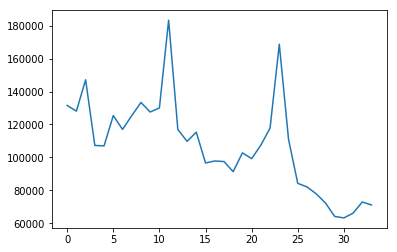

In [26]:
plt.plot(train_month.groupby('date_block_num').sum()['item_cnt_month'])


In [34]:
regr = linear_model.LinearRegression()
regr.fit(x1,y1)
y_pred = regr.predict(x2).clip(0.,20.)

print("Root Mean squared error (RMSE): %.2f" % np.sqrt(mean_squared_error(y2.clip(0.,20.), y_pred)))

Root Mean squared error (RMSE): 0.45


In [42]:
regr = linear_model.BayesianRidge()
regr.fit(x1,y1)
y_pred = regr.predict(x2).clip(0.,20.)

print("Root Mean squared error (RMSE): %.2f" % np.sqrt(mean_squared_error(y2.clip(0.,20.), y_pred)))

Root Mean squared error (RMSE): 0.45


In [35]:
reg = sklearn.ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=18)
reg.fit(x1,y1)
y_pred = reg.predict(x2).clip(0.,20.)

print("Root Mean squared error (RMSE): %.2f" % np.sqrt(mean_squared_error(y2.clip(0.,20.), y_pred)))

Root Mean squared error (RMSE): 0.41


In [ ]:
from statsmodels.tsa.arima_model import ARMA

arma_model = ARMA(x)